In [1]:
import math
import random
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import time

PROGRAM_START = time.time()

def binary_to_decimal(binary_string):
    return int('0b' + binary_string, 2)

def decoded(binary_dict):
    decoded_dict = {}
    for key, val in binary_dict.items():
        key = key[::-1]
        decoded_dict[f'{binary_to_message(key)}'] = val
    return decoded_dict

def message_to_binary(message):
    binary_string = ''
    for char in message:
        binary_string += f'{ord(char):0{8}b}'
    return binary_string

def binary_to_message(binary_string):
    message = ''
    for i in range(len(binary_string)//8):
        message += chr(int(binary_string[8*i:8*i+8], 2))
    return message

def initialise_quantum_circuit(binary_message):
    q1 = QuantumRegister(len(binary_message))
    circuit = QuantumCircuit(q1)
    for index, item in enumerate(binary_message):
        if item == '1':
            circuit.x(index)
    return circuit

def bits_agree(own_bits, received_bits, tolerance):
    agree = 0
    bits = len(own_bits)
    for i in range(len(own_bits)):
        if own_bits[i] == received_bits[i]:
            agree += 1
    print(f'Percent agreement: {agree/bits*100}%')
    if agree/bits >= tolerance:
        return True
    return False

def transmit_bits(bits):
    n = len(bits)//2
    remaining_bits = bits
    transmit = ''
    for i in range(n):
        random_index = random.randint(0, len(remaining_bits)-1)
        transmit += remaining_bits[random_index]
        remaining_bits = remaining_bits[:random_index] + remaining_bits[random_index+1:]

    return remaining_bits

def BB84(message = '0', attempts=0, EVE_ENABLED = False, attempt_tolerance = 3):

    print(f'Message from Alice: {message}')

    bin_message = message_to_binary(message)

    # Alice!

    # Create a new circuit with two qubits
    qc = initialise_quantum_circuit(bin_message)

    basis = ''.join([f'{random.randint(0,1)}' for i in range(len(bin_message))]) # generate random basis from alice
    print(f'Alice basis: {basis}')

    for i, c in enumerate(basis):
        if c == '1':
            qc.h(i)

    qc.barrier()

    # EVE interferes:
    if EVE_ENABLED:
        eve_guess = ''.join([f'{random.randint(0,1)}' for i in range(len(bin_message))])
        for i, c in enumerate(eve_guess):
            if c == '1':
                qc.h(i)
        qc.measure_all()
        qc.barrier()

    # Sent to Bob!!
    basis_guess = ''.join([f'{random.randint(0,1)}' for i in range(len(bin_message))])
    print(f'Bob basis: {basis_guess}')
    # Bob guesses
    for i, c in enumerate(basis_guess):
        if c == '1':
            qc.h(i)

    qc.measure_all()

    drawing = qc.draw("mpl", measure_arrows=False, fold=-1)
    simulator = AerSimulator()
    qc = transpile(qc, simulator)

    result = simulator.run(qc).result()
    counts = result.get_counts()
    if EVE_ENABLED:
        bob_counts = {}
        eve_counts = {}
        for key, count in counts.items():
            # Each key looks like 'q2q1 ... q0'
            parts = key.split(' ')
            one_line = parts[0]   # keep only the newest measurement line (rightmost or leftmost depending on order)
            bob_counts[one_line] = bob_counts.get(one_line, 0) + count
    else:
        bob_counts = counts
    dec_counts = decoded(bob_counts)

    # Alice announces her basis

    shared_basis = ''
    shared_bits_bob = ''
    shared_bits_alice = ''

    for i in range(len(basis)):
        if basis[i] == basis_guess[i]:
            shared_basis += f'{basis[i]}'
            key = list(counts.keys())[0]
            key = key[::-1]
            shared_bits_bob += key[i]
        else:
            shared_basis += 'x'

    for i in range(len(basis)):
        if basis[i] == basis_guess[i]:
            shared_basis += f'{basis[i]}'
            shared_bits_alice += bin_message[i]
        else:
            shared_basis += 'x'

    print(f'Shared bits: {shared_bits_bob}, {shared_bits_alice}')
    if shared_bits_bob != shared_bits_alice:
        print(f'SHARED BITS NOT EQUAL: KEY IS DIFFERENT => nonsense produced in communication')
    print(f'Shared basis: {shared_basis}')

    shared_bits_bob = shared_bits_bob

    # Alice randomly chooses n = k/2 bits to transmit

    transmitted_bits_alice = transmit_bits(shared_bits_alice)
    print(f'Transmitted bits by Alice: {transmitted_bits_alice}')

    transmitted_bits_bob = transmit_bits(shared_bits_bob)
    print(f'Transmitted bits by Bob: {transmitted_bits_bob}')

    if bits_agree(transmitted_bits_alice, transmitted_bits_bob, tolerance=0.66):
        print(f"Success! Shared bits: {shared_bits_bob}")
    elif attempts <= attempt_tolerance and time.time() - PROGRAM_START <= 100:
        print(f"Failed! Restarting!\n{'-'*16}")
        print(attempts)
        BB84(message, attempts+1, EVE_ENABLED)
    elif time.time() - PROGRAM_START > 100:
        print(f'Program timeout!')
    else:
        print(f"Line insecure!")
    # Return a drawing of the circuit using MatPlotLib ("mpl").
    return drawing


Message from Alice: QFF
Alice basis: 110100010100010011111011
Bob basis: 101001000110110001000101
Shared bits: 00001011010, 00001011010
Shared basis: 1xxx0x0x01x0x100x1xxxxx11xxx0x0x01x0x100x1xxxxx1
Transmitted bits by Alice: 000100
Transmitted bits by Bob: 000100
Percent agreement: 100.0%
Success! Shared bits: 00001011010


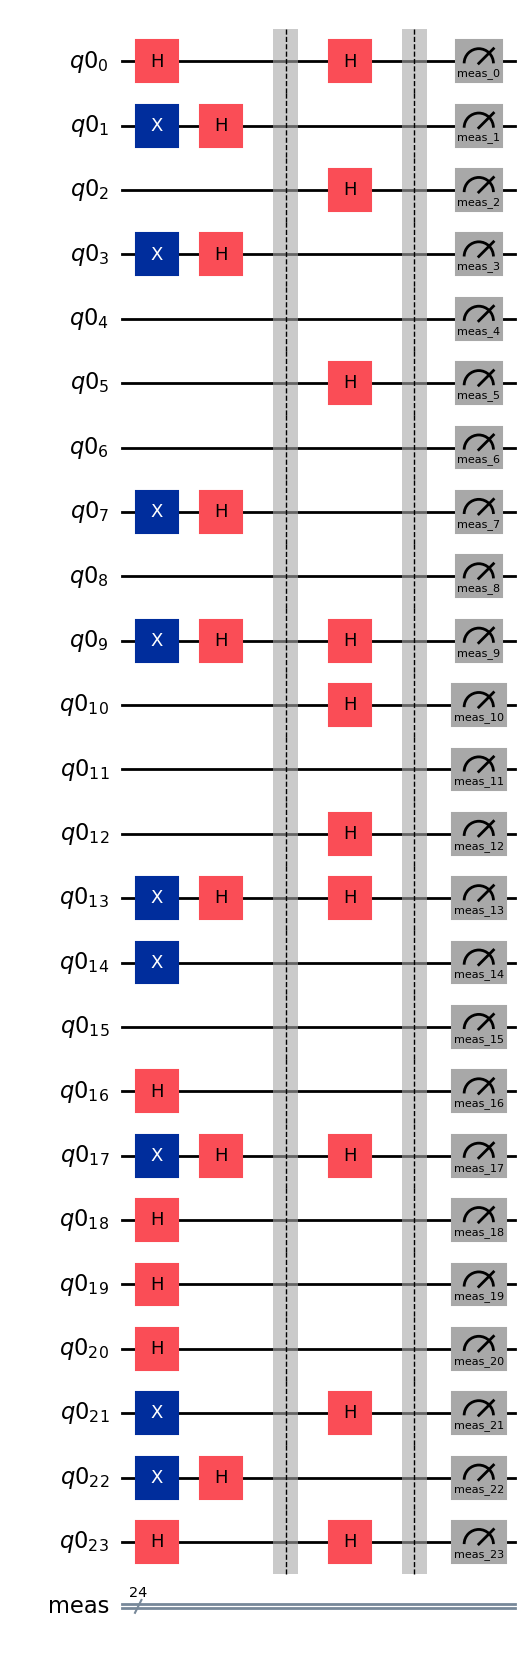

In [2]:
BB84(message='QFF', EVE_ENABLED=False, attempt_tolerance=3)

Message from Alice: qc
Alice basis: 0010110000011110
Bob basis: 1000010010110111
Shared bits: 111011001, 110011001
SHARED BITS NOT EQUAL: KEY IS DIFFERENT => nonsense produced in communication
Shared basis: x0x0x100x0x1x11xx0x0x100x0x1x11x
Transmitted bits by Alice: 10100
Transmitted bits by Bob: 11101
Percent agreement: 60.0%
Failed! Restarting!
----------------
0
Message from Alice: qc
Alice basis: 1001000011110111
Bob basis: 1111000010111000
Shared bits: 010011010, 010001010
SHARED BITS NOT EQUAL: KEY IS DIFFERENT => nonsense produced in communication
Shared basis: 1xx100001x11xxxx1xx100001x11xxxx
Transmitted bits by Alice: 01010
Transmitted bits by Bob: 01010
Percent agreement: 100.0%
Success! Shared bits: 010011010


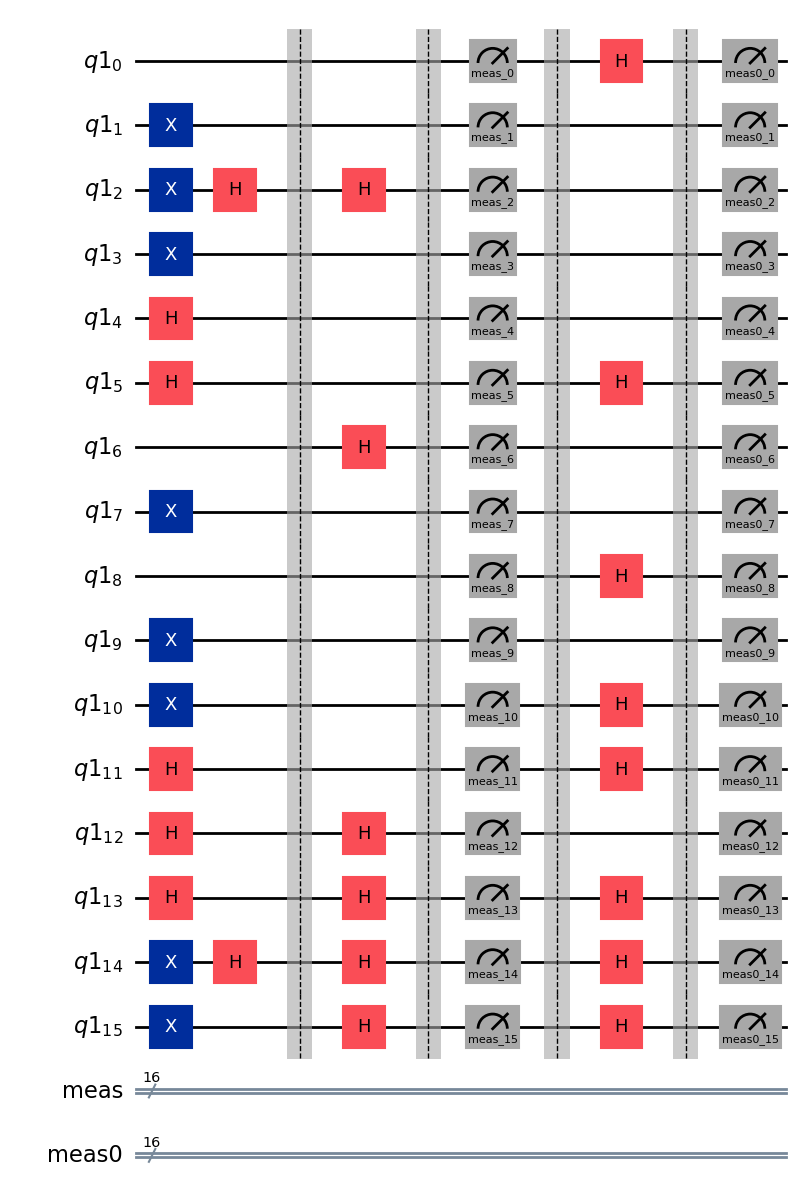

In [3]:
BB84(message='qc', EVE_ENABLED=True, attempt_tolerance=3)